# Introduction to Neural Networks and Deep Learning

# Chapter 1: Hands on Neural Networks and CNNs

## Prof. Aldo Humberto Romero, Physics Department, West Virginia University

## A lot of these notebooks are based on the course prepared at West Virginia University by the research computing group led by Aldo Humberto Romero by mostly done by Guillermo Avendaño-Franco.


In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2023-02-01T15:52:57.551888-05:00

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.9.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit



import time
start = time.time()
chapter_number = 1
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
chapter_number = 2
import time
start = time.time()

In [4]:
%watermark -iv

tensorflow: 2.11.0
matplotlib: 3.6.3
numpy     : 1.24.1



In [5]:
epoch_reduction_factor = 1.0
if len(tf.config.list_physical_devices('GPU')) == 0:
    print("Using TensorFlow CPU only, lowering the number of epochs")
    epoch_reduction_factor = 0.5

Using TensorFlow CPU only, lowering the number of epochs


In [ ]:
# IN what follows, we will use data that is stored in the subdirectory data in your current directory
# if you are using google colab to study this material, you will have to
#  Upload the data directory into your google drive
#  Link your google drive into your google collab, this is done by uncommenting the following lines

# from google.colab import drive

###  This line will take you to your google account, where you give permission to google collab to have access to it
# drive.mount('/content/gdrive')

## if you want to see the content, just type
# !ls "/content/gdrive/My Drive/"

## END OF LINES TO UNCOMMENT

# now, when you are trying to access the data in collab, you have change for example the line

#  ./data/keras/datasets/mnist.npz

# to

# /content/gdrive/My Drive/data/keras/datasets/mnist.npz


## IMPORTANT

To use this notebook and the next ones you need to download the data necessary for that. You can do it by following the link

https://drive.google.com/drive/folders/1x-LNDzPQ-AivI9xCM8h4EWg8ppzgfXD6?usp=share_link



# The MNIST Dataset of handwritten digits

The MNIST dataset of handwritten digits is a classical problem in Machine Learning and an iconic problem in Convolutional Neural Networks.

The MNIST database was constructed from joining two datasets/databases. The NIST's Special Database 3 and Special Database 1. Both datasets contain binary images of handwritten digits. NIST originally designated SD-3 as their training set and SD-1 as their test set. However, SD-3 is much cleaner and easier to recognize than SD-1. The reason for this can be found in the fact that SD-3 was collected among Census Bureau employees, while SD-1 was collected among high-school students. Drawing sensible conclusions from learning experiments requires that the result be independent of the choice of the training set and test among the complete set of samples. Therefore it was necessary to build a new database by mixing NIST's datasets.

The MNIST training set is composed of 30,000 patterns from SD-3 and 30,000 patterns from SD-1. For the test set, 5,000 patterns were taken from SD-3 and 5,000 patterns from SD-1. The 60,000 pattern training set contained examples from approximately 250 writers. We made sure that the sets of writers of the training set and test set were disjoint.

The dataset has a training set of 60,000 examples and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.

Yann LeCun has a page dedicated to the [MNIST DATASET](http://yann.lecun.com/exdb/mnist) with a list of publications where the dataset has been used.

The advantage of using these kinds of datasets is that all the preprocessing and normalization has been done, and some Machine Learning and Deep Learning Frameworks include it with the code or provide easy routines to download it. Let's explore this dataset using TensorFlow and the Keras library.

In [6]:
def load_data():
    path = './data/keras/datasets/mnist.npz'

    with np.load(path, allow_pickle=True) as f:  # pylint: disable=unexpected-keyword-arg
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [7]:
# **NOTE:** This only works with an internet connection
#
# mnist = tf.keras.datasets.mnist
# (train_images, train_labels), (test_images, test_labels) = mnist.load_data()

(train_images, train_labels), (test_images, test_labels) = load_data()

We have now 4 numpy arrays `train_images`, `train_labels`, `test_images`, and `test_labels`. 
The shapes of those arrays follows:

In [8]:
train_images.shape

(60000, 28, 28)

In [9]:
test_images.shape

(10000, 28, 28)

In [10]:
train_labels.shape

(60000,)

In [11]:
test_labels.shape

(10000,)

It will be pointless to look at all those images but we can have a peek into how they look for a small sample of them.

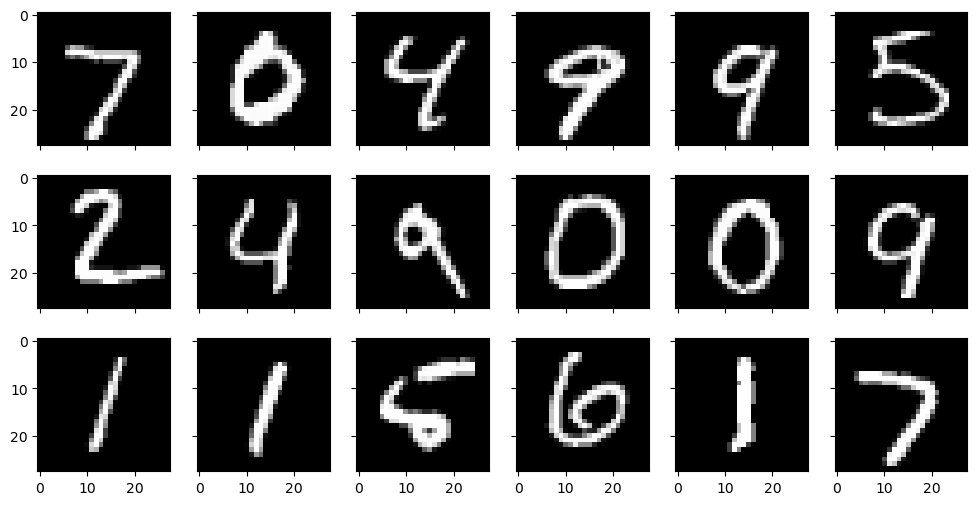

In [12]:
N=3
M=6
fig, axs = plt.subplots(N,M,sharex=True, sharey=True, figsize=(12,6))
for i in range(N):
    for j in range(M):
        axs[i,j].imshow(test_images[N*j+i], cmap='gray', interpolation='none')

Each image is a $28 \times 28$ grayscale bitmap. Let's see one of them

In [13]:
test_images[0].shape[0]

28

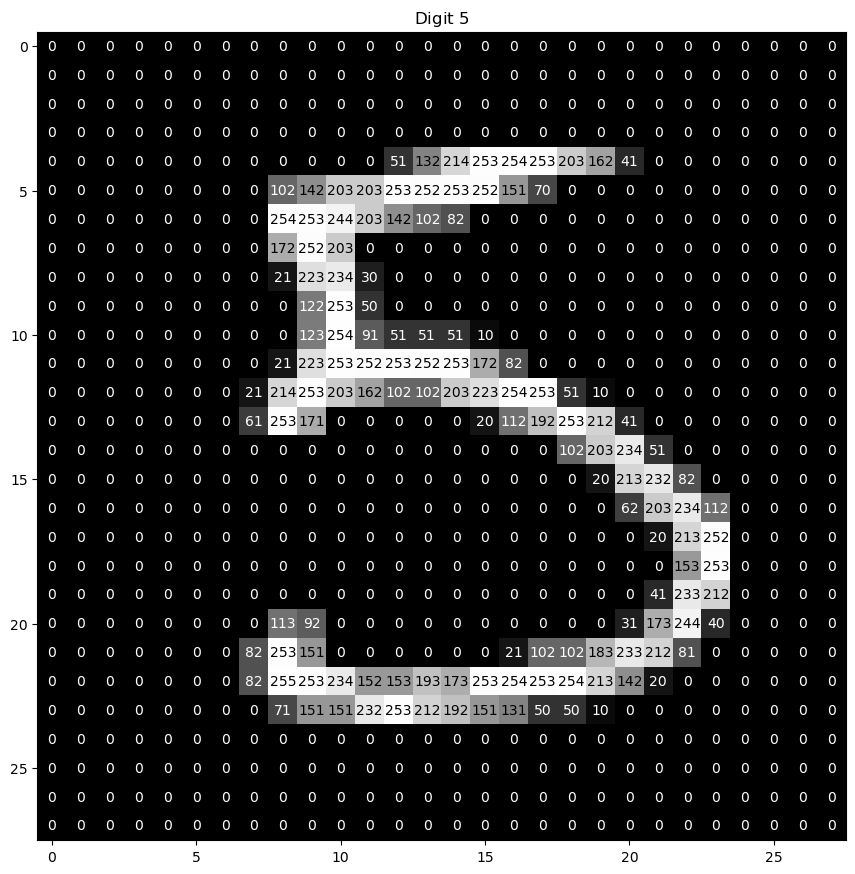

In [14]:
image_num=15
plt.gcf().set_size_inches(18.5, 10.5)
plt.imshow(test_images[image_num], cmap='gray', interpolation='none')
plt.title(r'Digit ${}$'.format(test_labels[image_num]));
for i in range(test_images[image_num].shape[0]):
    for j in range(test_images[image_num].shape[1]):
        if test_images[image_num][i][j]<128:
            fontcolor='white'
        else:
            fontcolor='black'
        plt.text(j,i,str(test_images[image_num][i][j]),color=fontcolor, 
                 horizontalalignment='center',
                 verticalalignment='center')

## Transforming the images into a 1-D vector

Our first task is to work out the simplest possible Neural Network model just to show how the TensorFlow framework functions. Then we will gradually implement our way to a quite sophisticated and accurate convolutional neural network for this same problem. 

First, we need to convert the images into 1D vectors. In NumPy that is called a `reshape`. The data is the same, but it now looks like $60000 \times 784$ array instead of the $60000 \times 28 \times 28$.

Another, change is to convert the original values of the array from integers into floating point numbers and divide those by 255 to get a value *normalized* between $0$ and $1$. This is a convenience as many Deep Learning models work better with values in small ranges.

In [15]:
train_images = train_images.reshape(60000, 784) 
test_images = test_images.reshape(10000, 784)
test_images = test_images.astype('float32') 
train_images = train_images.astype('float32')
test_images /= 255 
train_images /= 255

## Defining the model, our first Dense Neural Network

It is time to design the model. Models in Keras (tensorflow) are defined as a sequence of layers. 

We create a Sequential model and add layers one at a time until we are happy with our network architecture. The first thing to get right is to ensure the input layer has the correct number of input features. This can be specified when creating the first layer with the input_shape argument and setting it to (784,) for presenting the 784 input variables as a vector.

We want the network to take $784$ values in the input and feed with them the first layer of $64$ neurons which in turn feed another layer of $64$ to finalize with another layer of $10$. For the activation functions, we will use **ReLU** the function that we saw before. 

Like this

<div>
    <br>
  <table>
  <tr>
    <th><img src="./fig/NN_Basic.png" width="600" /></th>
  </tr>
  </table>
</div>      






In [18]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)), 
            tf.keras.layers.Dense(64, activation='relu'), 
            tf.keras.layers.Dense(10, activation='softmax'),
])

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                50240     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________


### Softmax activation

The final activation function will be a **softmax**. Softmax is a mathematical function that converts a vector of numbers into a vector of probabilities, where the probabilities of each value are proportional to the relative scale of each value in the vector. Therefore, the function **softmax** will return 10 values where the sum of them is 1. They will indicate the probability of each input to be associated to one of the 10 digits (multiclass classification problem). 

The standard (unit) softmax function $\sigma : \mathbb{R}^K\to (0,1)^K$ is defined $K>1$ by the formula

$$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}} \ \ \ \ \text{ for } i = 1, \dotsc , K \text{ and } \mathbf z=(z_1,\dotsc,z_K) \in \mathbb{R}^K.$$

In our case, $K=10$ and **softmax** is exactly the function we need to classify the digits.

In simple terms, **softmax** applies an exponential to each element $z_i$ of the vector $\mathbf z$ and normalizes these values by dividing by the sum of all these exponentials; this normalization ensures that the sum of the components of the output vector $\sigma(\mathbf z)$ is 1. This is the reason why we can take the output as the probability of the input image being any of the 10 digits.

There is another advantage of using softmax. The values returned at the end of the last layer could be of all sorts, negative values, large and small. softmax reduces all that to all positive, less than 1 set of values. 
See the table below for some examples:

In [20]:
z = np.array([ 8.1, -17.5, 10.6, 1.2, -1.5, 13.9,  -3.4, -5.4, 0.05, -2.0])

In [21]:
exp_z=np.exp(z)
exp_z

array([3.29446808e+03, 2.51099916e-08, 4.01348374e+04, 3.32011692e+00,
       2.23130160e-01, 1.08816136e+06, 3.33732700e-02, 4.51658094e-03,
       1.05127110e+00, 1.35335283e-01])

In [22]:
sm_z=np.exp(z)/np.sum(np.exp(z))
sm_z

array([2.91134799e-03, 2.21899019e-14, 3.54674793e-02, 2.93401408e-06,
       1.97181921e-07, 9.61616959e-01, 2.94922276e-08, 3.99133898e-09,
       9.29016740e-07, 1.19596880e-07])

In [23]:
np.sum(np.exp(z)/np.sum(np.exp(z)))

1.0000000000000002

In [24]:
for i in range(10):
    print('|{:d}|{:.3f}|{:.3e}|{:.3e}|'.format(i,z[i],exp_z[i],sm_z[i]))

|0|8.100|3.294e+03|2.911e-03|
|1|-17.500|2.511e-08|2.219e-14|
|2|10.600|4.013e+04|3.547e-02|
|3|1.200|3.320e+00|2.934e-06|
|4|-1.500|2.231e-01|1.972e-07|
|5|13.900|1.088e+06|9.616e-01|
|6|-3.400|3.337e-02|2.949e-08|
|7|-5.400|4.517e-03|3.991e-09|
|8|0.050|1.051e+00|9.290e-07|
|9|-2.000|1.353e-01|1.196e-07|


| Digit | Ouptut |Exponential | Normalized |
| --- | --- | --- | --- |
|0|8.100|3.294e+03|2.911e-03|
|1|-17.500|2.511e-08|2.219e-14|
|2|10.600|4.013e+04|3.547e-02|
|3|1.200|3.320e+00|2.934e-06|
|4|-1.500|2.231e-01|1.972e-07|
|5|13.900|1.088e+06|9.616e-01|
|6|-3.400|3.337e-02|2.949e-08|
|7|-5.400|4.517e-03|3.991e-09|
|8|0.050|1.051e+00|9.290e-07|
|9|-2.000|1.353e-01|1.196e-07|

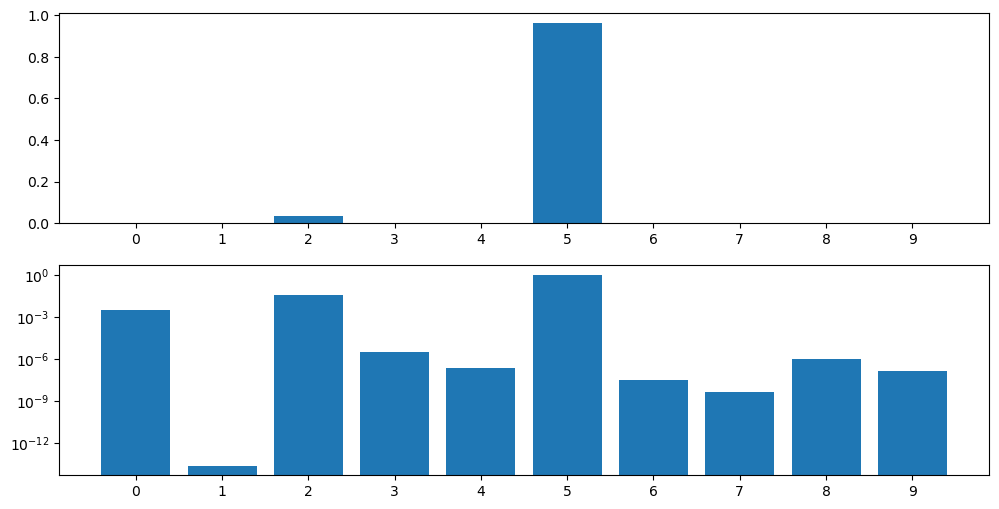

In [25]:
names = [ str(x) for x in np.arange(10)]
values = sm_z

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.bar(names, values, log=False);
plt.subplot(212)
plt.bar(names, values, log=True);

## Compiling the model, defining the backpropagation optimizer, loss function, and metrics

TensorFlow will use the arguments of the `compile` method to organize the procedure that will use to adjust the weights and biases. The values that control the output of our neural network. The optimizer `adam` is a usual choice for many Deep Learning problems. 

While training the deep learning optimizers model, we need to modify each epoch’s weights and minimize the loss function. An optimizer is a function or an algorithm that modifies the attributes of the neural network, such as weights and learning rate. Thus, it helps in reducing the overall loss and improve the accuracy. The problem of choosing the right weights for the model is a daunting task, as a deep learning model generally consists of millions of parameters. It raises the need to choose a suitable optimization algorithm for your application. Hence understanding these algorithms is necessary before having a deep dive into the field.


`sparse_categorical_crossentropy` is often used in classification problems like this. Using `accuracy` is a good metric knowing that we have a perfect balance between all the digits present in the dataset.

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Cross Entropy Loss function

The loss function is the function that we try to minimize and should account for measuring a distance between the desired value and the value returned from the network under current weights and biases.

Given the very particular and sensible way we have constructed these outputs.

We could be using the Root Mean Square (RMS) as a loss function. The RMS defined as

$$\text{loss}_\text{RMS} = \sqrt{\frac{1}{n} \sum_{i=1}^n \left(y_i - y_i^{obj} \right)^2 }$$.

Where $y_i$ are the values obtained from the neural network and $y_i^{obj}$ and the values objective. 
This function is not a good idea for our case. See on the figure above that except for 1 value all the others are very small, it will be hard for an algorithm to know how in which direction to change the parameters when all produce such small values. We need somehow a way to undo the flattening of the **softmax**.

The Cross-Entropy Loss function is a good way to define the error across all possibilities. Better than RMS. 
The Cross entropy function is defined as:

$$\text{loss}_\text{CE} =  - \sum_{i=1}^n y_i^{obj} \log y_i$$

Let's assume that in our case above, we are indeed in the presence of a digit $5$.
The value of $y^{obj}$ will be:

In [27]:
y_obj=np.zeros(10)
y_obj[5]=1
y_obj

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

Our neural network returned these values after the softmax:

In [28]:
sm_z

array([2.91134799e-03, 2.21899019e-14, 3.54674793e-02, 2.93401408e-06,
       1.97181921e-07, 9.61616959e-01, 2.94922276e-08, 3.99133898e-09,
       9.29016740e-07, 1.19596880e-07])

Let's compute the loss function using the equation above:

In [29]:
np.log(sm_z)

array([ -5.83913908, -31.43913908,  -3.33913908, -12.73913908,
       -15.43913908,  -0.03913908, -17.33913908, -19.33913908,
       -13.88913908, -15.93913908])

In [30]:
-np.dot(y_obj,np.log(sm_z))

0.03913907868076204

This is the value of our loss. This is the value that we want to minimize.

## Fitting the model

Here is where the real processing takes place, the values of weights and biases are changed using the examples provided from the `train_images` and `train_labels`. This is a very high-level routine that is also capable of validating the model with the `test_images` and `test_labels`.

Each time a dataset passes through an algorithm, it is said to have completed an epoch (one entire passing of training data through the algorithm). The training data is always broken down into small batches

We will understand later on how mathematical procedures are used to find the weights and biases until our network return correct answers for the images both in our training and test sets.

This is a very small problem so you can train this model on a modern computer in a couple of minutes.

In [31]:
hist_dnn1 = model.fit(train_images, 
                    train_labels, 
                    batch_size=128, 
                    epochs=int(epoch_reduction_factor*40), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

Epoch 1/20


2023-02-01 16:03:23.542819: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


469/469 [==============================] - 1s 1ms/step - loss: 0.3901 - accuracy: 0.8899 - val_loss: 0.2088 - val_accuracy: 0.9389
Epoch 2/20
469/469 [==============================] - 1s 1ms/step - loss: 0.1659 - accuracy: 0.9514 - val_loss: 0.1373 - val_accuracy: 0.9607
Epoch 3/20
469/469 [==============================] - 0s 1ms/step - loss: 0.1209 - accuracy: 0.9644 - val_loss: 0.1155 - val_accuracy: 0.9668
Epoch 4/20
469/469 [==============================] - 0s 1ms/step - loss: 0.0960 - accuracy: 0.9711 - val_loss: 0.1029 - val_accuracy: 0.9694
Epoch 5/20
469/469 [==============================] - 0s 1ms/step - loss: 0.0790 - accuracy: 0.9763 - val_loss: 0.1027 - val_accuracy: 0.9689
Epoch 6/20
469/469 [==============================] - 0s 1ms/step - loss: 0.0655 - accuracy: 0.9803 - val_loss: 0.0963 - val_accuracy: 0.9705
Epoch 7/20
469/469 [==============================] - 0s 1ms/step - loss: 0.0570 - accuracy: 0.9822 - val_loss: 0.1032 - val_accuracy: 0.9701
Epoch 8/20
469/46

## Measuring accuracy and loss. The curse of overfitting

At the end of $40$ cycles with the training data we got an accuracy of $0.9991$. Very good at least for the training set. 

However, when we measure the accuracy with the test set. The set of data **unseen** by the model during the fitting the value is reduced to $0.97$.

Somehow, our neural network is learning to produce the right results for the values that it knows, but is not as good for the values that have not seen. This is called **overfitting** and to measure it we had to separate the $10000$ examples that we called `test_images` and `test_labels`.

In [32]:
def plot_accuracy(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'],'o-')
    plt.plot(history.history['val_accuracy'],'o-')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left');

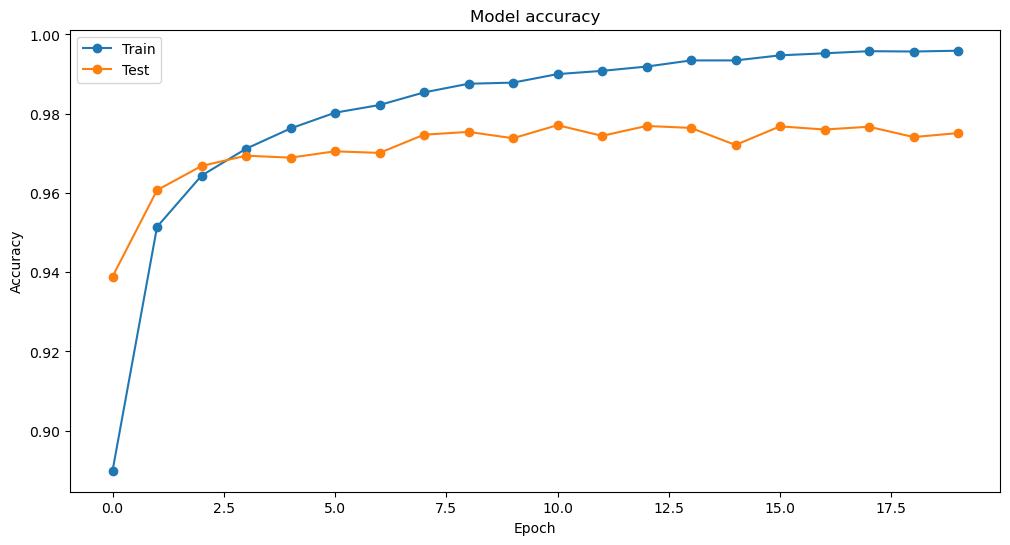

In [33]:
plot_accuracy(hist_dnn1);

A similar picture we get from the loss function. Notice that we plot the figure below using a semilog plot.
The value of the loss function is decreasing, with some degradations beyond epoch 15.

However, it is remarkable that even beyond epoch 4, the loss function is not improving with the test set. It is going up over time. Another sign of **overfitting**. 

In [34]:
def plot_loss(history):
    plt.figure(figsize=(12, 6))
    plt.semilogy(history.history['loss'],'o-')
    plt.semilogy(history.history['val_loss'],'o-')
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left');

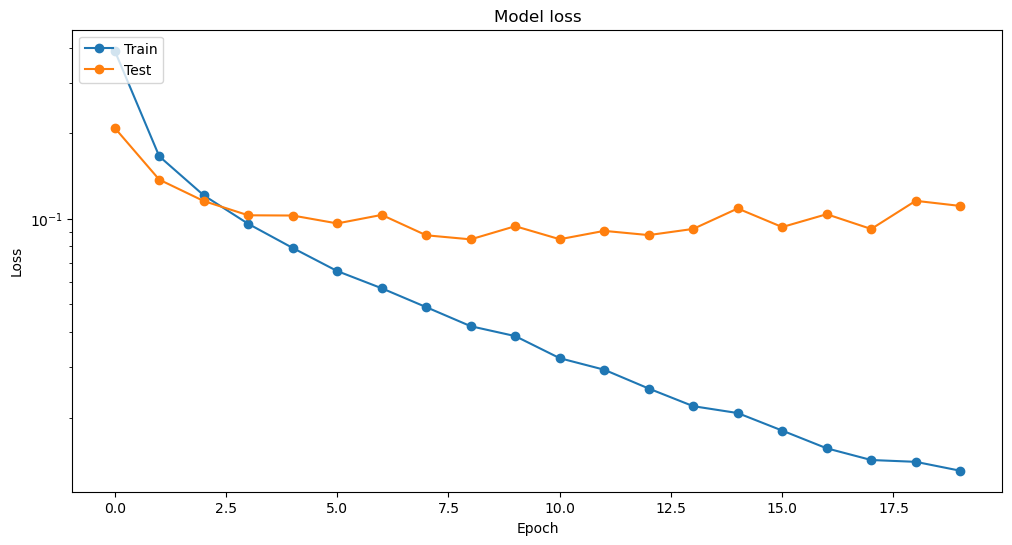

In [35]:
plot_loss(hist_dnn1);

Let's see if you can do better. Still, with the idea of a dense neural network, there are two things we can try.
Making the networks thicker or make them deeper. 

Let's see how far we can go with these options.

## Thicker Neural Network

In our first network, we use a couple of layers with $64$ neurons in them. What about doubling that figure to $128$?
We can think that with more neurons there are more parameters and those extra parameters will offer a richer landscape for optimizing better the weights.

As many things in Deep Learning and science in general, arguments, no matter how beautiful ones can be beaten by ugly facts. 

In [36]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)), 
            tf.keras.layers.Dense(128, activation='relu'), 
            tf.keras.layers.Dense(10, activation='softmax'),
])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [39]:
hist_dnn2 = model.fit(train_images, 
                    train_labels, 
                    batch_size=128, 
                    epochs=int(epoch_reduction_factor*40), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

Epoch 1/20
469/469 [==============================] - 1s 2ms/step - loss: 0.3125 - accuracy: 0.9142 - val_loss: 0.1581 - val_accuracy: 0.9523
Epoch 2/20
469/469 [==============================] - 1s 2ms/step - loss: 0.1233 - accuracy: 0.9633 - val_loss: 0.1045 - val_accuracy: 0.9687
Epoch 3/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0846 - accuracy: 0.9741 - val_loss: 0.0873 - val_accuracy: 0.9732
Epoch 4/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0632 - accuracy: 0.9811 - val_loss: 0.0789 - val_accuracy: 0.9765
Epoch 5/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0488 - accuracy: 0.9853 - val_loss: 0.0772 - val_accuracy: 0.9752
Epoch 6/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0400 - accuracy: 0.9878 - val_loss: 0.0735 - val_accuracy: 0.9773
Epoch 7/20
469/469 [==============================] - 1s 2ms/step - loss: 0.0313 - accuracy: 0.9904 - val_loss: 0.0803 - val_accuracy: 0.9766
Epoch 

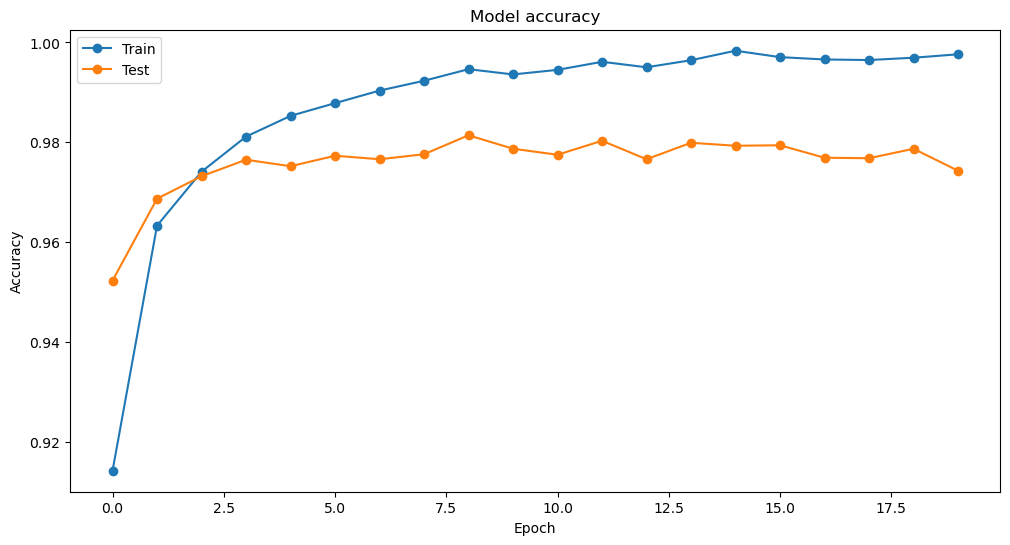

In [40]:
plot_accuracy(hist_dnn2);

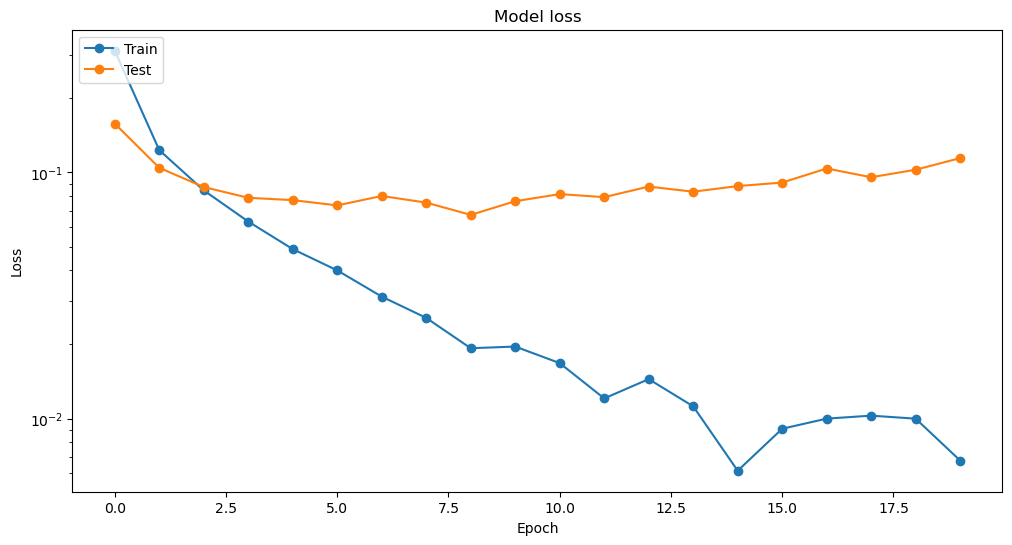

In [41]:
plot_loss(hist_dnn2);

The result is not indicative that **bigger** is **better**. 

We double the number of parameters, from 55 thousand to 118 thousand (See the summary of the model).

Neither the accuracy for the test set has been better or the loss function for the test set is lower. We are again stuck with unseen cases that are not well learning. 
Learning is not about memorizing what you see, learning is also about generalization, prospection, conexions.
That is true for our human meaning of "Learning" and the machine meaning for "learning".

What about deeper neural networks? 

## Deeper neural networks

Return to our original network, but this time instead we will add a couple of extra layers with $64$ neurons each.
Will this network start learning *deeper*?

In [42]:
model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(784,)), 
            tf.keras.layers.Dense(64, activation='relu'), 
            tf.keras.layers.Dense(64, activation='relu'), 
            tf.keras.layers.Dense(64, activation='relu'), 
            tf.keras.layers.Dense(10, activation='softmax'),
])

In [43]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                50240     
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 10)                650       
                                                                 
Total params: 63,370
Trainable params: 63,370
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [45]:
hist_dnn3 = model.fit(train_images, 
                    train_labels, 
                    batch_size=128, 
                    epochs=int(epoch_reduction_factor*40), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

Epoch 1/20
469/469 [==============================] - 1s 1ms/step - loss: 0.3971 - accuracy: 0.8794 - val_loss: 0.1684 - val_accuracy: 0.9495
Epoch 2/20
469/469 [==============================] - 1s 1ms/step - loss: 0.1508 - accuracy: 0.9550 - val_loss: 0.1206 - val_accuracy: 0.9632
Epoch 3/20
469/469 [==============================] - 1s 1ms/step - loss: 0.1101 - accuracy: 0.9671 - val_loss: 0.1169 - val_accuracy: 0.9639
Epoch 4/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0908 - accuracy: 0.9728 - val_loss: 0.0982 - val_accuracy: 0.9704
Epoch 5/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0760 - accuracy: 0.9765 - val_loss: 0.1009 - val_accuracy: 0.9689
Epoch 6/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0606 - accuracy: 0.9810 - val_loss: 0.0871 - val_accuracy: 0.9730
Epoch 7/20
469/469 [==============================] - 1s 1ms/step - loss: 0.0547 - accuracy: 0.9827 - val_loss: 0.0979 - val_accuracy: 0.9724
Epoch 

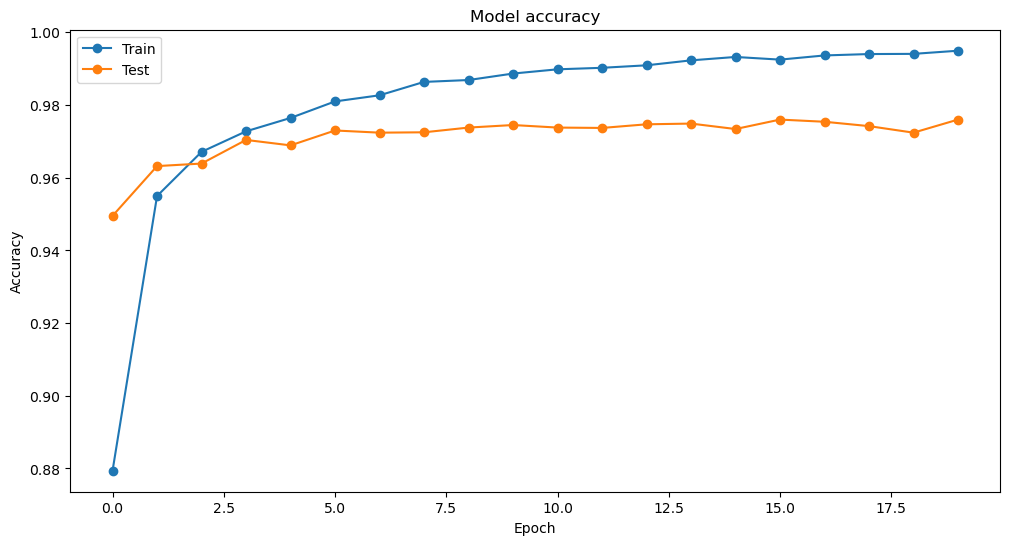

In [46]:
plot_accuracy(hist_dnn3);

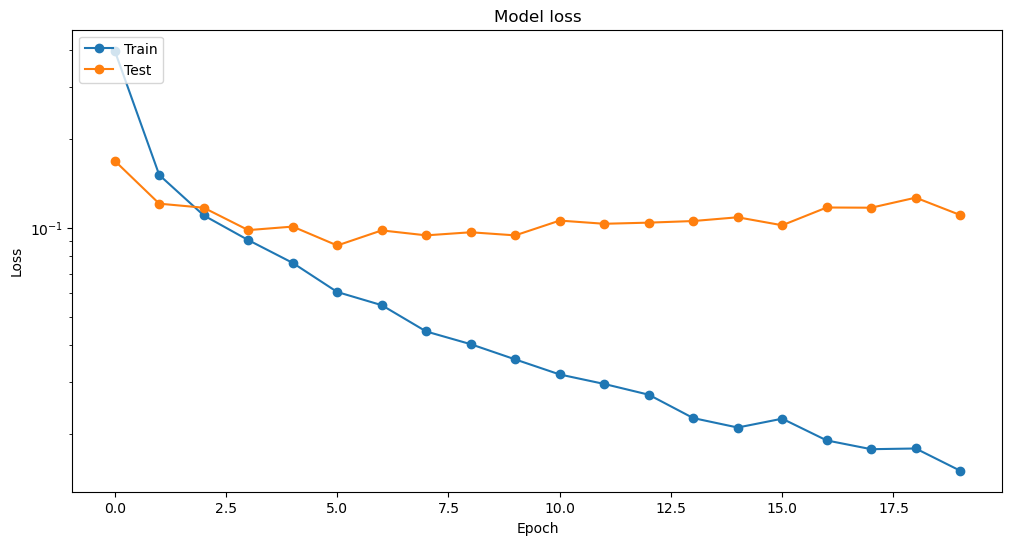

In [47]:
plot_loss(hist_dnn3);

Well, no *thicker* or *deeper* is helping us. With so many parameters, our network is remembering how to answer correctly for the training set but is not learning to generalize the parameters to also answer correctly for unseen images.

## Quick detour: Overfitting and the art of fitting elephants

John von Neumann famously said:

*With four parameters I can fit an elephant, and with five I can make him wiggle his trunk.*

This is quite appropriate to raise your attention to the risk of adding more parameters that do not improve anything.

Here is a realization of von Neumann's quote on a webpage from [John D Cook](https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/). 

The original code was created by Piotr A. Zolnierczuk based on the paper:

    “Drawing an elephant with four complex parameters” 
    by Jurgen Mayer, Khaled Khairy, and Jonathon Howard,  
    Am. J. Phys. 78, 648 (2010), DOI:10.1119/1.3254017.

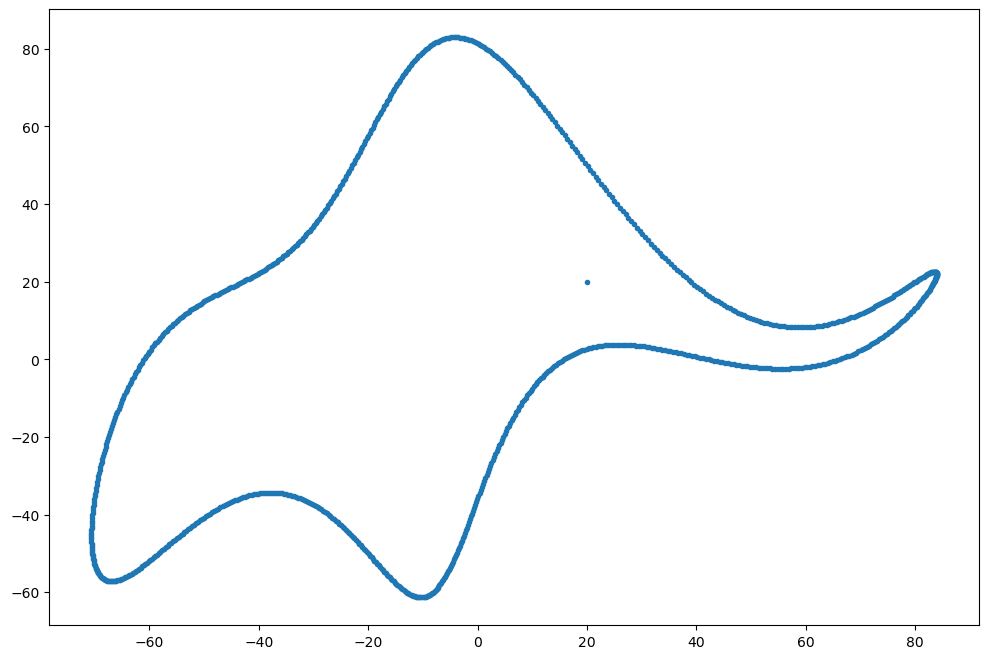

In [48]:
"""
Author: Piotr A. Zolnierczuk (zolnierczukp at ornl dot gov)

Based on a paper by:
Drawing an elephant with four complex parameters
Jurgen Mayer, Khaled Khairy, and Jonathon Howard,
Am. J. Phys. 78, 648 (2010), DOI:10.1119/1.3254017
"""
import numpy as np
import pylab

# elephant parameters
p1, p2, p3, p4 = (50 - 30j, 18 +  8j, 12 - 10j, -14 - 60j )
p5 = 40 + 20j # eyepiece

def fourier(t, C):
    f = np.zeros(t.shape)
    A, B = C.real, C.imag
    for k in range(len(C)):
        f = f + A[k]*np.cos(k*t) + B[k]*np.sin(k*t)
    return f

def elephant(t, p1, p2, p3, p4, p5):
    npar = 6
    Cx = np.zeros((npar,), dtype='complex')
    Cy = np.zeros((npar,), dtype='complex')

    Cx[1] = p1.real*1j
    Cx[2] = p2.real*1j
    Cx[3] = p3.real
    Cx[5] = p4.real

    Cy[1] = p4.imag + p1.imag*1j
    Cy[2] = p2.imag*1j
    Cy[3] = p3.imag*1j

    x = np.append(fourier(t,Cx), [-p5.imag])
    y = np.append(fourier(t,Cy), [p5.imag])

    return x,y

plt.figure(figsize=(12, 8))
x, y = elephant(np.linspace(0,2*np.pi,1000), p1, p2, p3, p4, p5)
pylab.plot(y,-x,'.')
pylab.show()

## No thicker, no deeper, what is next?

Lets summarize the results from our 3 networks:

| Network Architecture | Number of trainable parameters | Test Lost | Test Accuracy | Validation Loss | Validation Accuracy |
|---|---|---|---|---|---|
| 64 $\times$ 64 $\times$ 10 | 55,050 | 0.0033 | 0.9991 | 0.1379 | 0.9762 |
| 128 $\times$ 128 $\times$ 10 | 118,282 | 0.0064 | 0.9979 | 0.1261 | 0.9782 | 
| 64 $\times$ 64 $\times$ 64 $\times$ 64 $\times$ 10 | 63,370 | 0.0096 | 0.9971 | 0.1556 | 0.9749 |

So adding more neurons on a layer or adding more layers is not helping. Where is the problem?

For physicists, there is a guiding principle in many areas:

      Follow the symmetries!

Imagine one of the images in our training set. What if we take the image and we shift the image one pixel.
From our eyes (and brain). The image is the same. Translation symmetry is trivial for an image but from the point of view of our neural networks, the original image and the translated image look very different. 
Many input cells are changed and this is an unfortunate effect of flattening our 2D array into a 1D array. 

In addition to the flattening, the neural network is not using the grid arrangement of the pixels and the corresponding arrays.

These limitations have been addressed by the so-called **Convolutional Neural Networks** (CNN). CNN's are the correct way of doing image recognition with neural networks.

# Convolutional Neural Networks

**A convolutional neural network (CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image, and be able to differentiate one from the other**. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets can learn these filters/characteristics.

## AlexNet

AlexNet won the ImageNet Large Scale Visual Recognition Competition (ILSVRC) and revolutionized Deep Learning.

![AlexNet1](./fig/AlexNet1.png)

![AlexNet2](./fig/AlexNet2.png)


## A convolution

<!--
![Convolution](./fig/convolution.svg)

![Convolution 11](./fig/convolution11.svg)

![Convolution 23](./fig/convolution23.svg)
-->

<img src="./fig/convolution.svg" width=500 height=500 />
<img src="./fig/convolution11.svg" width=500 height=500 />
<img src="./fig/convolution23.svg" width=500 height=500 />

![CNN](./fig/cnn.jpeg)



As seen from this figure, CNN consists of several convolutional and subsampling layers optionally followed by fully connected layers. 

Let us say that our input to the convolutional layer is a $m \times m \times r$ pixels in an image where $m$ is the height and width of the image and $r$ is the number of channels, e.g. an RGB image has $r=3$. The convolutional layer will have $k$ filters (or kernels) of size $n \times n \times q$ where n is smaller than the dimension of the image and $q$ can either be the same as the number of channels r or smaller and may vary for each kernel. The size of the filters gives rise to the locally connected structure which is each convolved with the image to produce k feature maps of size $m−n+1$. 


A simple demonstration is shown in the figure below, where we assume a binary picture and a single filter of a 3x3 matrix. The primary purpose of Convolution is to extract features from the input image. Convolution preserves the spatial relationship between pixels by learning image features using small squares of input data. The orange square slide over the figure and for each 3x3 overlap, I multiply every element of the 3x3 submatrix of the figure with the convolution and then I add all elements afterward. 

![ConvNet](./fig/ConvNet.jpeg)
 
 Let see how this works

![CNN](./fig/MovieCN.gif)


 It is clear that different values of the filter matrix will produce different Feature Maps for the same input image.
 
 Typical filter matrices are now described. 
 
 For edge detection:
 $
\begin{bmatrix}
1&0&-1\\
0&0&0\\
-1&0&1\\
\end{bmatrix}
\;\;
\begin{bmatrix}
0&1&0\\
1&-4&1\\
0&1&0\\
\end{bmatrix}
\;\;
\begin{bmatrix}
-1&-1&-1\\
-1&8&-1\\
-1&-1&-1\\
\end{bmatrix}
$

For sharpen:
$
\begin{bmatrix}
0&-1&0\\
-1&5&-1\\
0&-1&0\\
\end{bmatrix}
$

In practice, a CNN learns the values of these filters on its own during the training process (although we still need to specify parameters such as the number of filters, filter size, architecture of the network, etc. before the training process). The more filters we have, the more image features get extracted, and the better our network becomes at recognizing patterns in unseen images.

The other step that is described in this section is the pooling. Spatial Pooling (also called subsampling or downsampling) reduces the dimensionality of each feature map but retains the most important information. Spatial Pooling can be of different types: Max, Average, Sum, etc.

## MNIST classification using a simple CNN

In [49]:
#mnist = tf.keras.datasets.mnist
#(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images = train_images.reshape(60000, 28, 28, 1) 
test_images = test_images.reshape(10000, 28, 28, 1) 
train_images, test_images = train_images/255, test_images/255

In [50]:
tf.keras.layers.MaxPooling2D(2,2),

(<keras.layers.pooling.max_pooling2d.MaxPooling2D at 0x2a6bcac20>,)

In [51]:
model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)), 
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(100, activation='relu'),
                            tf.keras.layers.Dense(10, activation='softmax') ])

In [52]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense_14 (Dense)            (None, 100)               2163300   
                                                                 
 dense_15 (Dense)            (None, 10)                1010      
                                                                 
Total params: 2,164,630
Trainable params: 2,164,630
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

In [54]:
hist_cnn1 = model.fit(train_images, 
                    train_labels, 
                    batch_size=32, 
                    epochs=int(epoch_reduction_factor*20), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2256 - accuracy: 0.9333 - val_loss: 0.1083 - val_accuracy: 0.9668
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0779 - accuracy: 0.9760 - val_loss: 0.0676 - val_accuracy: 0.9769
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0468 - accuracy: 0.9858 - val_loss: 0.0599 - val_accuracy: 0.9808
Epoch 4/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0301 - accuracy: 0.9905 - val_loss: 0.0571 - val_accuracy: 0.9820
Epoch 5/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.0538 - val_accuracy: 0.9845
Epoch 6/10
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0137 - accuracy: 0.9958 - val_loss: 0.0533 - val_accuracy: 0.9856
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0593 - val_accur

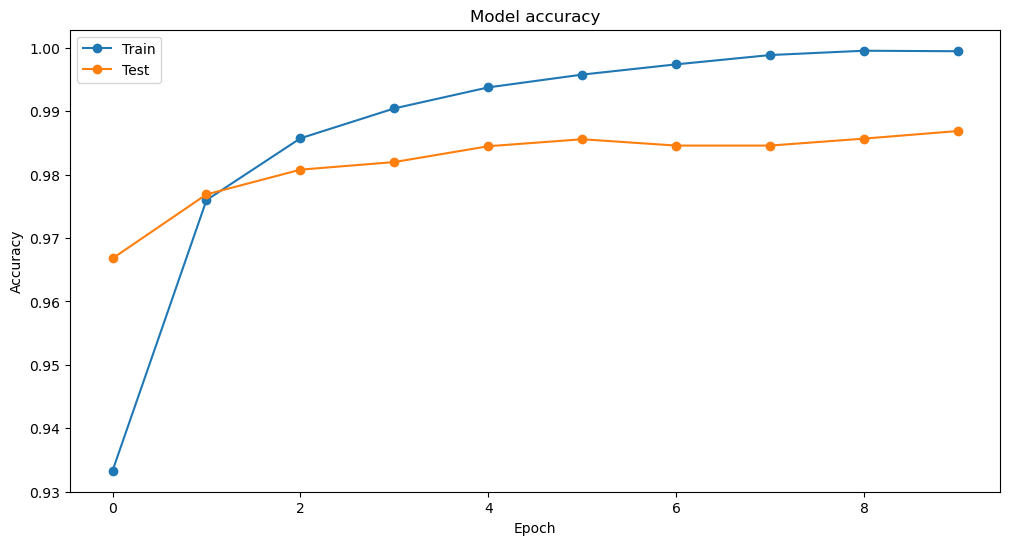

In [55]:
plot_accuracy(hist_cnn1);

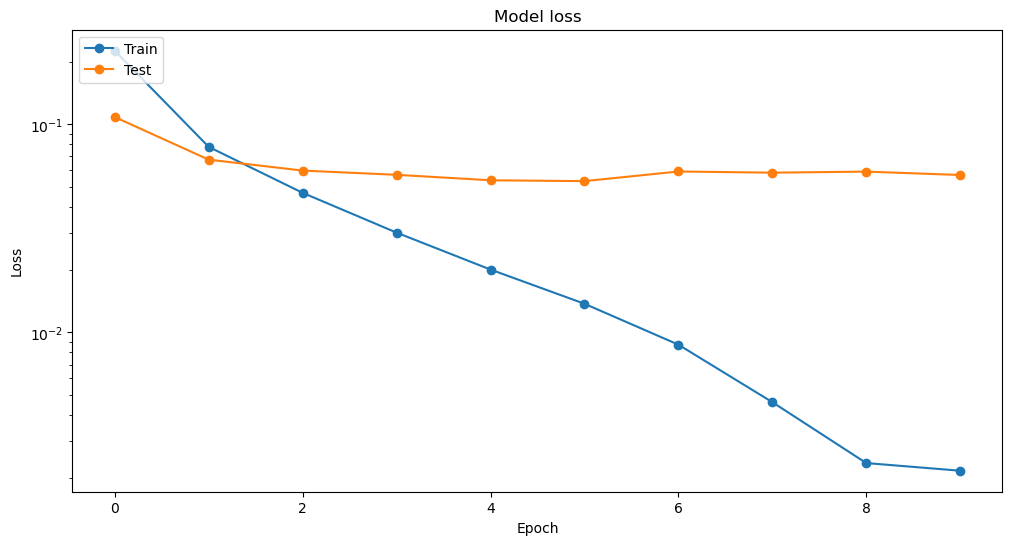

In [56]:
plot_loss(hist_cnn1);

## Adding another convolutional layer

In [57]:
model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)), 
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(100, activation='relu'),
                            tf.keras.layers.Dense(10, activation='softmax') ])

In [58]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_16 (Dense)            (None, 100)              

In [59]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

In [60]:
hist_cnn2 = model.fit(train_images, 
                    train_labels, 
                    batch_size=32, 
                    epochs=int(epoch_reduction_factor*20), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1819 - accuracy: 0.9438 - val_loss: 0.0490 - val_accuracy: 0.9837
Epoch 2/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0513 - accuracy: 0.9840 - val_loss: 0.0411 - val_accuracy: 0.9864
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0346 - accuracy: 0.9892 - val_loss: 0.0355 - val_accuracy: 0.9885
Epoch 4/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0269 - accuracy: 0.9915 - val_loss: 0.0308 - val_accuracy: 0.9884
Epoch 5/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0206 - accuracy: 0.9941 - val_loss: 0.0376 - val_accuracy: 0.9878
Epoch 6/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.0369 - val_accuracy: 0.9873
Epoch 7/10
1875/1875 [==============================] - 12s 7ms/step - loss: 0.0126 - accuracy: 0.9960 - val_loss: 0.0328 - val_ac

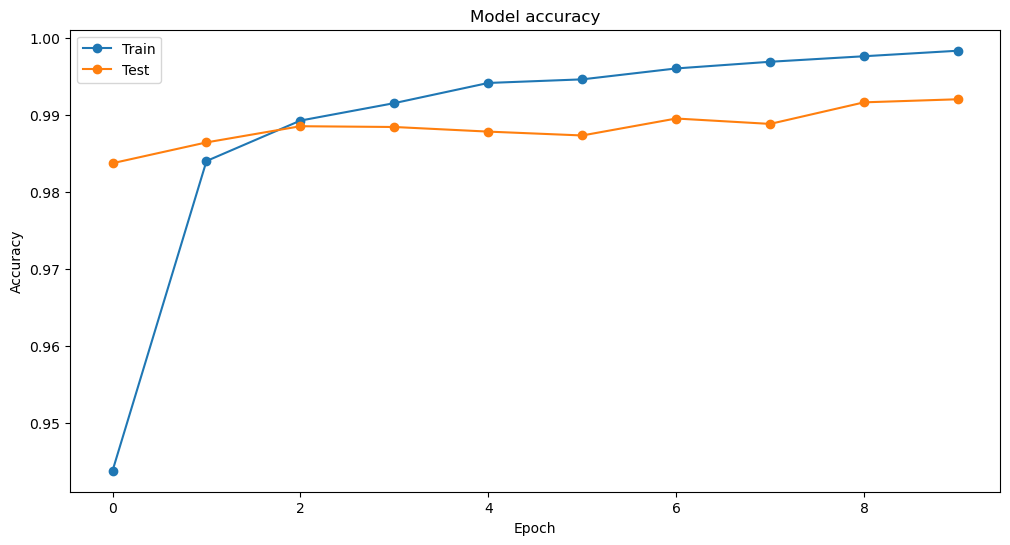

In [61]:
plot_accuracy(hist_cnn2);

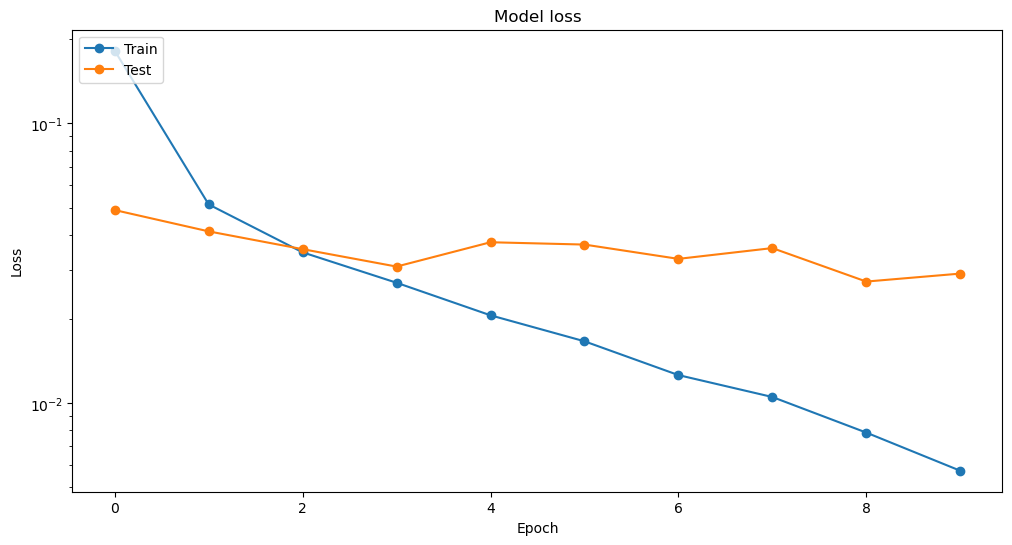

In [62]:
plot_loss(hist_cnn2);

## Adding dropout

It looks counterintuitive but sometimes it is good to prune networks. The technique is called dropout and it is used to reduce overfitting.  

When using the Dropout layer, it randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent **overfitting**. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

Note that the Dropout layer only applies during **training**, ie no neurons are dropped during inference. When using `model.fit`, training will be appropriately set to True automatically.

In [63]:
model = tf.keras.Sequential([
                            tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)), 
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                            tf.keras.layers.MaxPooling2D(2,2),
                            tf.keras.layers.Dropout(0.25),
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(100, activation='relu'),
                            tf.keras.layers.Dropout(0.25),
                            tf.keras.layers.Dense(10, activation='softmax') ])

In [64]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 1600)             

In [65]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

In [66]:
hist_cnn3 = model.fit(train_images, 
                    train_labels, 
                    batch_size=32, 
                    epochs=int(epoch_reduction_factor*20), 
                    verbose=1, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.2618 - accuracy: 0.9150 - val_loss: 0.0563 - val_accuracy: 0.9819
Epoch 2/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0865 - accuracy: 0.9737 - val_loss: 0.0386 - val_accuracy: 0.9875
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0631 - accuracy: 0.9804 - val_loss: 0.0332 - val_accuracy: 0.9896
Epoch 4/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0521 - accuracy: 0.9839 - val_loss: 0.0256 - val_accuracy: 0.9912
Epoch 5/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0454 - accuracy: 0.9858 - val_loss: 0.0280 - val_accuracy: 0.9900
Epoch 6/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0398 - accuracy: 0.9878 - val_loss: 0.0268 - val_accuracy: 0.9913
Epoch 7/10
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0358 - accuracy: 0.9886 - val_loss: 0.0261 - val_ac

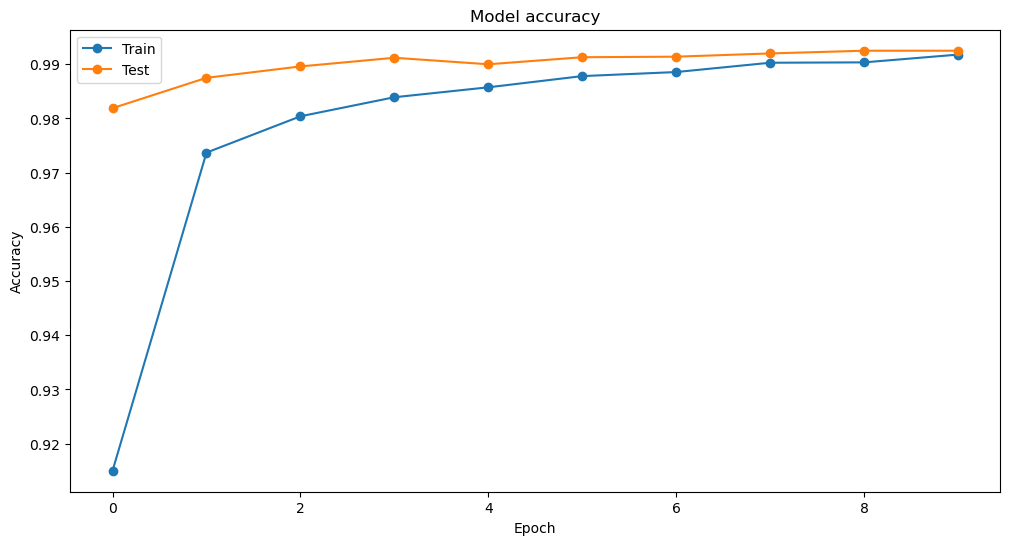

In [67]:
plot_accuracy(hist_cnn3);

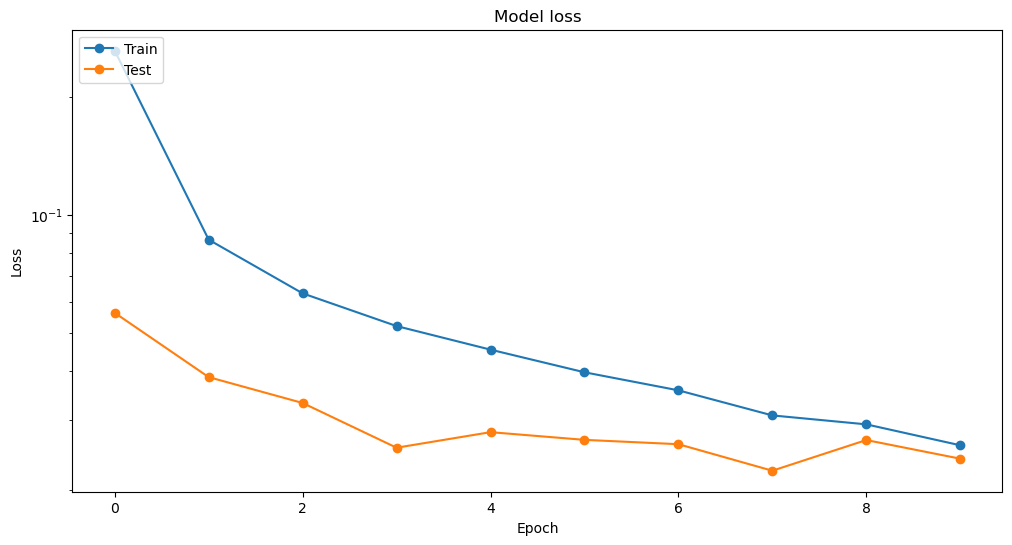

In [68]:
plot_loss(hist_cnn3);

## Summarizing all neural networks we used

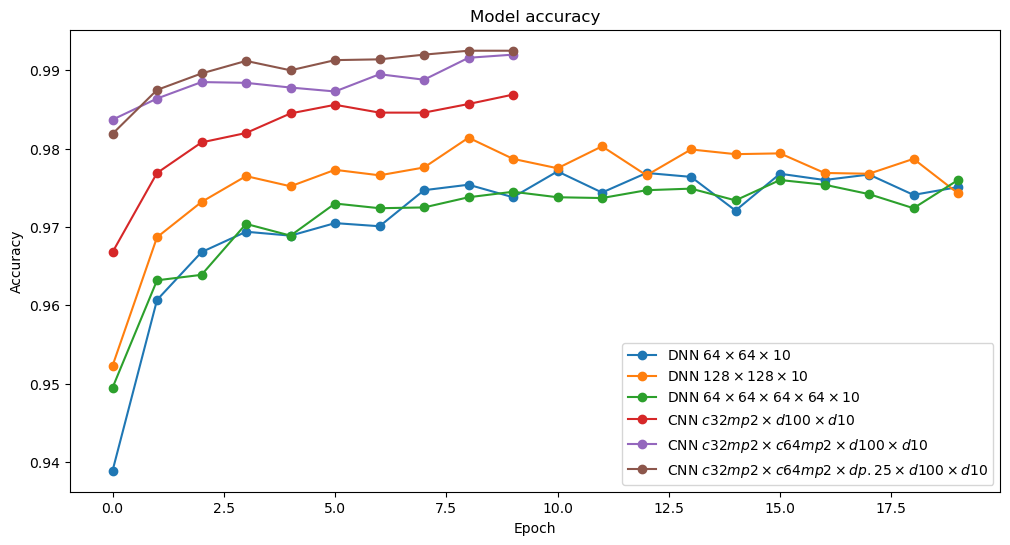

In [69]:
plt.figure(figsize=(12, 6))

for ihist in [hist_dnn1, hist_dnn2, hist_dnn3, hist_cnn1, hist_cnn2, hist_cnn3]:
    plt.plot(ihist.history['val_accuracy'],'o-')

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend([r'DNN $64 \times 64 \times 10$', 
            r'DNN $128 \times 128 \times 10$', 
            r'DNN $64 \times 64 \times 64 \times 64 \times 10$', 
            r'CNN $c32mp2 \times d100 \times d10$', 
            r'CNN $c32mp2 \times c64mp2 \times d100 \times d10$', 
            r'CNN $c32mp2 \times c64mp2 \times dp.25 \times d100 \times d10$'], loc='lower right');

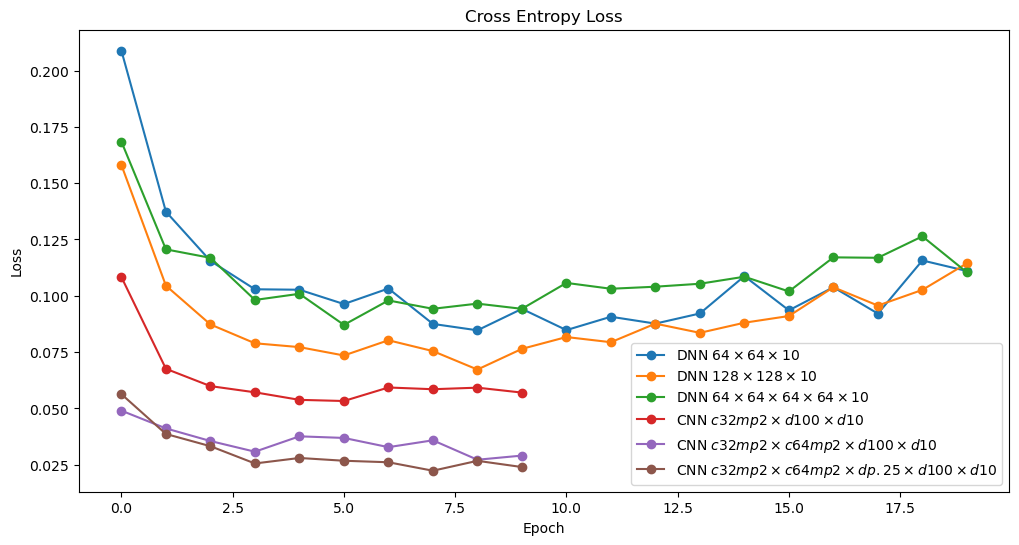

In [70]:
plt.figure(figsize=(12, 6))

for ihist in [hist_dnn1, hist_dnn2, hist_dnn3, hist_cnn1, hist_cnn2, hist_cnn3]:
    plt.plot(ihist.history['val_loss'],'o-')

plt.title('Cross Entropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend([r'DNN $64 \times 64 \times 10$', 
            r'DNN $128 \times 128 \times 10$', 
            r'DNN $64 \times 64 \times 64 \times 64 \times 10$', 
            r'CNN $c32mp2 \times d100 \times d10$', 
            r'CNN $c32mp2 \times c64mp2 \times d100 \times d10$', 
            r'CNN $c32mp2 \times c64mp2 \times dp.25 \times d100 \times d10$'], loc='lower right');

# Building Deep Learning models using low-level TensorFlow 1.x

As we saw above, Keras offers an easy and high-level API for building both dense and convolutional Neural Networks with just a few lines of code.

At this point is also illustrative how the model can be built explicitly on TensorFlow using the old TensorFlow 1.x API.

We start with a set of functions and classes for processing the original MNIST dataset. 

In [71]:
"""Functions for downloading and reading MNIST data."""

import gzip
import os
import shutil
import urllib.request
import numpy
import tempfile
SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'

def maybe_download(filename, work_directory, data_directory):
    """Download the data from Yann's website, unless it's already here."""
    if not os.path.exists(work_directory):
        os.mkdir(work_directory)
    filepath = os.path.join(data_directory, filename)
    filepath2 = os.path.join(work_directory, filename)
    if not os.path.exists(filepath):
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL + filename, filepath)
        statinfo = os.stat(filepath)
        print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
    shutil.copyfile(filepath, filepath2)
    return filepath2

def _read32(bytestream):
    dt = numpy.dtype(numpy.uint32).newbyteorder('>')
    return numpy.frombuffer(bytestream.read(4), dtype=dt)


def extract_images(filename):
    """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2051:
            raise ValueError(
                'Invalid magic number %d in MNIST image file: %s' %
                (magic, filename))
        num_images = _read32(bytestream)[0]
        rows = _read32(bytestream)[0]
        cols = _read32(bytestream)[0]
        print(f"Detected {num_images} images of size {rows} x {cols}")
        buf = bytestream.read(rows * cols * num_images)
        data = numpy.frombuffer(buf, dtype=numpy.uint8)
        data = data.reshape(num_images, rows, cols, 1)
        return data


def dense_to_one_hot(labels_dense, num_classes=10):
    """Convert class labels from scalars to one-hot vectors."""
    num_labels = labels_dense.shape[0]
    index_offset = numpy.arange(num_labels) * num_classes
    labels_one_hot = numpy.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot


def extract_labels(filename, one_hot=False):
    """Extract the labels into a 1D uint8 numpy array [index]."""
    print('Extracting', filename)
    with gzip.open(filename) as bytestream:
        magic = _read32(bytestream)
        if magic != 2049:
            raise ValueError(
                'Invalid magic number %d in MNIST label file: %s' %
                (magic, filename))
        num_items = _read32(bytestream)[0]
        buf = bytestream.read(num_items)
        labels = numpy.frombuffer(buf, dtype=numpy.uint8)
        if one_hot:
            return dense_to_one_hot(labels)
        return labels


class DataSet(object):
    def __init__(self, images, labels, fake_data=False):
        if fake_data:
            self._num_examples = 10000
        else:
            assert images.shape[0] == labels.shape[0], (
                "images.shape: %s labels.shape: %s" % (images.shape,
                                                       labels.shape))
            self._num_examples = images.shape[0]
            # Convert shape from [num examples, rows, columns, depth]
            # to [num examples, rows*columns] (assuming depth == 1)
            assert images.shape[3] == 1
            images = images.reshape(images.shape[0],
                                    images.shape[1] * images.shape[2])
            # Convert from [0, 255] -> [0.0, 1.0].
            images = images.astype(numpy.float32)
            images = numpy.multiply(images, 1.0 / 255.0)
        self._images = images
        self._labels = labels
        self._epochs_completed = 0
        self._index_in_epoch = 0

    @property
    def images(self):
        return self._images

    @property
    def labels(self):
        return self._labels

    @property
    def num_examples(self):
        return self._num_examples

    @property
    def epochs_completed(self):
        return self._epochs_completed

    def next_batch(self, batch_size, fake_data=False):
        """Return the next `batch_size` examples from this data set."""
        if fake_data:
            fake_image = [1.0 for _ in xrange(784)]
            fake_label = 0
            return [fake_image for _ in xrange(batch_size)], [
                fake_label for _ in xrange(batch_size)]
        start = self._index_in_epoch
        self._index_in_epoch += batch_size
        if self._index_in_epoch > self._num_examples:
            # Finished epoch
            self._epochs_completed += 1
            # Shuffle the data
            perm = numpy.arange(self._num_examples)
            numpy.random.shuffle(perm)
            self._images = self._images[perm]
            self._labels = self._labels[perm]
            # Start next epoch
            start = 0
            self._index_in_epoch = batch_size
            assert batch_size <= self._num_examples
        end = self._index_in_epoch
        return self._images[start:end], self._labels[start:end]


def read_data_sets(train_dir, data_dir, fake_data=False, one_hot=False):
    class DataSets(object):
        pass
    data_sets = DataSets()
    if fake_data:
        data_sets.train = DataSet([], [], fake_data=True)
        data_sets.validation = DataSet([], [], fake_data=True)
        data_sets.test = DataSet([], [], fake_data=True)
        return data_sets
    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
    VALIDATION_SIZE = 5000
    local_file = maybe_download(TRAIN_IMAGES, train_dir, data_dir)
    train_images = extract_images(local_file)
    local_file = maybe_download(TRAIN_LABELS, train_dir, data_dir)
    train_labels = extract_labels(local_file, one_hot=one_hot)
    local_file = maybe_download(TEST_IMAGES, train_dir, data_dir)
    test_images = extract_images(local_file)
    local_file = maybe_download(TEST_LABELS, train_dir, data_dir)
    test_labels = extract_labels(local_file, one_hot=one_hot)
    validation_images = train_images[:VALIDATION_SIZE]
    validation_labels = train_labels[:VALIDATION_SIZE]
    train_images = train_images[VALIDATION_SIZE:]
    train_labels = train_labels[VALIDATION_SIZE:]
    data_sets.train = DataSet(train_images, train_labels)
    data_sets.validation = DataSet(validation_images, validation_labels)
    data_sets.test = DataSet(test_images, test_labels)
    return data_sets

In [72]:
tempdir = tempfile.mkdtemp()
print(tempdir)

/var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/tmp8ibaqv4l


## Dense Neural Network with TensorFlow 1.x API

In [73]:
print("Building MNIST dataset")
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)
mnist = read_data_sets(tempdir, "./data/MNIST/raw", one_hot = True)

n_nodes_hl1 = 500
n_nodes_hl2 = 500
n_nodes_hl3 = 500
n_nodes_hl4 = 500

n_classes = 10
batch_size = 100

tf.compat.v1.disable_eager_execution()

x = tf.compat.v1.placeholder('float', [None, 784])
y = tf.compat.v1.placeholder('float')

def neural_network_model(data):
    print("Building Neural Network Model")
    hidden_1_layer = {'weights':tf.Variable(tf.random.normal([784, n_nodes_hl1])),
                      'biases':tf.Variable(tf.random.normal([n_nodes_hl1]))}

    hidden_2_layer = {'weights':tf.Variable(tf.random.normal([n_nodes_hl1, n_nodes_hl2])),
                      'biases':tf.Variable(tf.random.normal([n_nodes_hl2]))}

    hidden_3_layer = {'weights':tf.Variable(tf.random.normal([n_nodes_hl2, n_nodes_hl3])),
                      'biases':tf.Variable(tf.random.normal([n_nodes_hl3]))}

    hidden_4_layer = {'weights':tf.Variable(tf.random.normal([n_nodes_hl3, n_nodes_hl4])),
                      'biases':tf.Variable(tf.random.normal([n_nodes_hl4]))}

    output_layer = {'weights':tf.Variable(tf.random.normal([n_nodes_hl4, n_classes])),
                    'biases':tf.Variable(tf.random.normal([n_classes])),}


    l1 = tf.add(tf.matmul(data,hidden_1_layer['weights']), hidden_1_layer['biases'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1,hidden_2_layer['weights']), hidden_2_layer['biases'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2,hidden_3_layer['weights']), hidden_3_layer['biases'])
    l3 = tf.nn.relu(l3)

    l4 = tf.add(tf.matmul(l2,hidden_4_layer['weights']), hidden_4_layer['biases'])
    l4 = tf.nn.relu(l4)


    output = tf.matmul(l4,output_layer['weights']) + output_layer['biases']

    return output

def train_neural_network(x):
    print("Training the Neural Network")
    prediction = neural_network_model(x)
    # OLD VERSION:
    #cost = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(prediction,y) )
    # NEW:
    input_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=tf.stop_gradient(y))
    cost = tf.reduce_mean( input_tensor= input_tensor)
    optimizer = tf.compat.v1.train.AdamOptimizer().minimize(cost)

    hm_epochs = 10
    with tf.compat.v1.Session() as sess:
        # OLD:
        #sess.run(tf.initialize_all_variables())
        # NEW:
        sess.run(tf.compat.v1.global_variables_initializer())

        for epoch in range(hm_epochs):
            epoch_loss = 0
            for _ in range(int(mnist.train.num_examples/batch_size)):
                epoch_x, epoch_y = mnist.train.next_batch(batch_size)
                _, c = sess.run([optimizer, cost], feed_dict={x: epoch_x, y: epoch_y})
                epoch_loss += c

            print(f'Epoch {epoch}/{hm_epochs} loss: {epoch_loss:12.4e}')

        correct = tf.equal(tf.argmax(input=prediction, axis=1), tf.argmax(input=y, axis=1))

        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct, 'float'))
        print('Test accuracy:',accuracy.eval({x:mnist.test.images, y:mnist.test.labels}))

train_neural_network(x)

Building MNIST dataset
Extracting /var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/tmp8ibaqv4l/train-images-idx3-ubyte.gz
Detected 60000 images of size 28 x 28
Extracting /var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/tmp8ibaqv4l/train-labels-idx1-ubyte.gz
Extracting /var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/tmp8ibaqv4l/t10k-images-idx3-ubyte.gz
Detected 10000 images of size 28 x 28
Extracting /var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/tmp8ibaqv4l/t10k-labels-idx1-ubyte.gz
Training the Neural Network
Building Neural Network Model


2023-02-01 16:25:43.546897: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


Epoch 0/10 loss:   1.7160e+06
Epoch 1/10 loss:   4.0283e+05
Epoch 2/10 loss:   2.1757e+05
Epoch 3/10 loss:   1.2416e+05
Epoch 4/10 loss:   7.2183e+04
Epoch 5/10 loss:   4.7336e+04
Epoch 6/10 loss:   3.1459e+04
Epoch 7/10 loss:   2.4392e+04
Epoch 8/10 loss:   2.1507e+04
Epoch 9/10 loss:   2.0515e+04
Test accuracy: 0.9528


## Convolutional Neural Network with TensorFlow 1.x API

In [74]:
#from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets(".", one_hot=True)

mnist = read_data_sets(tempdir, "./data/MNIST/raw", one_hot = True)

x = tf.compat.v1.placeholder(tf.float32, [None, 784])
y_ = tf.compat.v1.placeholder(tf.float32, [None, 10])

x_image = tf.reshape(x, [-1,28,28,1])

Extracting /var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/tmp8ibaqv4l/train-images-idx3-ubyte.gz
Detected 60000 images of size 28 x 28
Extracting /var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/tmp8ibaqv4l/train-labels-idx1-ubyte.gz
Extracting /var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/tmp8ibaqv4l/t10k-images-idx3-ubyte.gz
Detected 10000 images of size 28 x 28
Extracting /var/folders/sd/7rq2vwcx7fd8stfzsvfnz9980000gq/T/tmp8ibaqv4l/t10k-labels-idx1-ubyte.gz


In [75]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1))
b_conv1 = tf.Variable(tf.constant(0.1,shape=[32]))
h_conv1 = tf.nn.relu(tf.nn.conv2d(input=x_image, filters=W_conv1,strides=[1, 1, 1, 1], padding='SAME') + b_conv1)
h_pool1 = tf.nn.max_pool2d(input=h_conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1))
b_conv2 = tf.Variable(tf.constant(0.1,shape=[64]))
h_conv2 = tf.nn.relu(tf.nn.conv2d(input=h_pool1, filters=W_conv2,strides=[1, 1, 1, 1], padding='SAME') + b_conv2)
h_pool2 = tf.nn.max_pool2d(input=h_conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 64, 1024], stddev=0.1))
b_fc1 = tf.Variable(tf.constant(0.1,shape=[1024]))
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

W_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1))
b_fc2 = tf.Variable(tf.constant(0.1,shape=[10]))
keep_prob = tf.compat.v1.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, rate=1 - (keep_prob))
y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [76]:
cross_entropy = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.compat.v1.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(input=y_conv,axis=1), tf.argmax(input=y_,axis=1))
accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))

sess = tf.compat.v1.InteractiveSession()

sess.run(tf.compat.v1.global_variables_initializer())

n_epochs=10
batch_size=50
n_samples=mnist.train.num_examples

for i in range(1,n_epochs+1):
    print(f'Epoch {i}/{n_epochs}')
    for j in range(1,int(n_samples/batch_size)+1):
        batch = mnist.train.next_batch(50)
        if j%100 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
            print(f'{j:4d}/{int(n_samples/batch_size):4d} training accuracy: {train_accuracy:7.4f}')
        train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("Test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Epoch 1/10
 100/1100 training accuracy:  0.9400
 200/1100 training accuracy:  0.9400
 300/1100 training accuracy:  0.9400
 400/1100 training accuracy:  0.9600
 500/1100 training accuracy:  0.8800
 600/1100 training accuracy:  0.9600
 700/1100 training accuracy:  0.9800
 800/1100 training accuracy:  0.9000
 900/1100 training accuracy:  0.9600
1000/1100 training accuracy:  0.9600
1100/1100 training accuracy:  1.0000
Epoch 2/10
 100/1100 training accuracy:  0.9600
 200/1100 training accuracy:  1.0000
 300/1100 training accuracy:  0.9600
 400/1100 training accuracy:  1.0000
 500/1100 training accuracy:  0.9800
 600/1100 training accuracy:  1.0000
 700/1100 training accuracy:  0.9800
 800/1100 training accuracy:  0.9600
 900/1100 training accuracy:  0.9800
1000/1100 training accuracy:  0.9800
1100/1100 training accuracy:  0.9600
Epoch 3/10
 100/1100 training accuracy:  1.0000
 200/1100 training accuracy:  0.9800
 300/1100 training accuracy:  0.9800
 400/1100 training accuracy:  1.0000
 500/

# Cleaning

In [77]:
shutil.rmtree(tempdir)

# Exercises

  1. MNIST is a relatively simple dataset. Try to get the simplest network that gives you a 95% accuracy with the validation data. 
     Check the number of trainable parameters as your measure of simplicity. Imagine that it will be deployed on very modest hardware and you cannot have the luxury of storing hundreds of thousands of parameters.

  1. What happens to the number of parameters if we remove the MaxPooling2D from the network architecture?
     Use model.summary() to check for that. Do not try to train such a network.
   

---

# References

There are many books about Deep Learning and many more on Machine Learning. 
This list is by no means an exhaustive list of books. I am listing the books from which I took inspiration. Also, I am listing materials where I found better ways to present topics. Often I am amazed by how people can create approachable materials for seemingly dry subjects.

The order of the books goes from divulgation and practical to the more rigorous and mathematical. Slides, blogs, and videos are those I have found over the internet or suggested by others.

### Selection of Books on Deep Learning

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Kelleher" 
       src="./fig/books/Deep Learning - Kelleher.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      John D. Kelleher<br>
      2019<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Charniak" 
       src="./fig/books/Introduction to Deep Learning - Charniak.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Eugene Charniak<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Skansi" 
       src="./fig/books/Introduction to Deep Learning - Skansi.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Sandro Skansi<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Subramanian" 
       src="./fig/books/Deep Learning with PyTorch - Subramanian.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Vishnu Subramanian<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Stevens" 
       src="./fig/books/Deep Learning with PyTorch - Stevens.png" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Eli Stevens, Luca Artiga and Thomas Viehmann<br>
      2020<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with Python - Chollet" 
       src="./fig/books/Deep Learning with Python - Chollet.jpg" 
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with Python (Second Edition)<br>
      François Chollet<br>
      2021<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Patterson" 
       src="./fig/books/Deep Learning - Patterson.jpeg"
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning, a practitioner's approach<br>
      Josh Patterson and Adam Gibson<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Goodfellow" 
       src="./fig/books/Deep Learning - Goodfellow.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      Ian Goodfellow, Yoshua Bengio, and Aaron Courville<br>
      2016<br>
  </div>
</div>

### Interactive Books

  * [Dive into Deep Learning](https://d2l.ai/index.html)<br>
    Interactive deep learning book with code, math, and discussions<br> 
    Implemented with PyTorch, NumPy/MXNet, and TensorFlow<br>
    Adopted at 300 universities from 55 countries


### Slides

  * John Urbanic's ["Deep Learning in one Afternoon"](https://www.psc.edu/wp-content/uploads/2022/04/Deep-Learning.pdf)<br>
An excellent fast, condensed introduction to Deep Learning.<br>
John is a Parallel Computing Scientist at Pittsburgh Supercomputing Center

  * [Christopher Olah's Blog](http://colah.github.io) is very good. For example about [Back Propagation](http://colah.github.io/posts/2015-08-Backprop)

  * Adam W. Harley on his CMU page offers [An Interactive Node-Link Visualization of Convolutional Neural Networks](https://www.cs.cmu.edu/~aharley/vis/)



### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelien Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml) and
   [Second Edition](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 
 * [3Blue1Brown Youtube Channel](https://www.youtube.com/watch?v=Ilg3gGewQ5U)
 
 ---

# Back of the Book

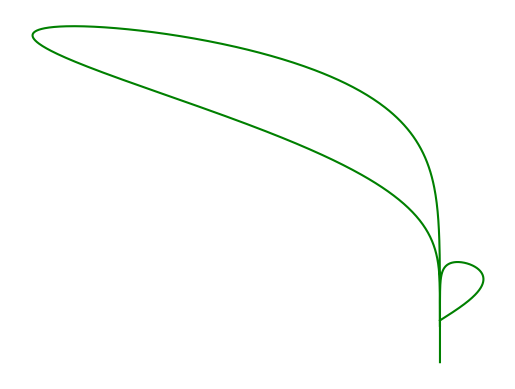

In [78]:
n = chapter_number
t = np.linspace(0, (2*(n-1)+1)*np.pi/2, 1000)
x = t*np.cos(t)**3
y = 9*t*np.sqrt(np.abs(np.cos(t))) + t*np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [81]:
end = time.time()
print(f'Chapter {chapter_number} took {int(end - start):d} seconds')

Chapter 2 took 6 seconds
